# Modeling Collective Behavior: El Farol Bar
    Aquino, Nathaniel Ken A.
    Nicasio, Mark Joseph C.

    4CSC

----

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import random
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter

In [4]:
# Parameters
N_AGENTS = 100
BAR_CAPACITY = 60
TOO_FEW = 20
WEEKS = 100
SEQUENCE_LENGTH = 300  # Keep 1:3 ratio for weeks to sequence length

# Generate dummy attendance history with high initial attendance
def generate_initial_attendance(weeks=SEQUENCE_LENGTH):
    return [random.randint(50, 80) for _ in range(weeks)]

# Build LSTM predictor
def build_lstm_model():
    model = Sequential([
        LSTM(32, input_shape=(SEQUENCE_LENGTH, 1), return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    # model.summary()  # Add model summary
    return model

# Q-learning Agent with LSTM, personality traits, and communication weight
class Agent:
    def __init__(self, agent_id, total_agents):
        self.agent_id = agent_id
        self.q_table = np.zeros((2,))  # 0: stay home, 1: go
        self.alpha = 0.1
        self.gamma = 0.95
        self.epsilon = 0.5  # Initial exploration rate
        self.lstm = build_lstm_model()
        self.past_attendance = generate_initial_attendance()
        self.recent_rewards = []
        # Social peers
        self.known_agents = random.sample(range(total_agents), k=random.randint(1, 10))
        # Communication trust weight (self vs peers)
        self.comm_weight = random.uniform(0.5, 1.0)

        # Pre-train LSTM on initial history
        X = np.array([
            self.past_attendance[i:i+SEQUENCE_LENGTH]
            for i in range(len(self.past_attendance) - SEQUENCE_LENGTH)
        ])
        y = np.array(self.past_attendance[SEQUENCE_LENGTH:])
        if len(X) > 0:
            self.lstm.fit(
                X.reshape(-1, SEQUENCE_LENGTH, 1),
                y,
                epochs=50,
                verbose=0
            )

    def adjust_epsilon(self):
        if self.recent_rewards:
            avg_reward = np.mean(self.recent_rewards)
            if avg_reward > 1:
                self.epsilon = max(0.1, self.epsilon * 0.95)
            elif avg_reward < 0:
                self.epsilon = min(1.0, self.epsilon * 1.05)

    def predict_attendance(self):
        seq = np.array(self.past_attendance[-SEQUENCE_LENGTH:]).reshape(1, SEQUENCE_LENGTH, 1)
        return self.lstm.predict(seq, verbose=0)[0][0]

    def decide(self, combined_pred, known_rewards):
        # Influence epsilon via known rewards
        if known_rewards:
            avg_known = np.mean(known_rewards)
            if avg_known > 1:
                self.epsilon = max(0.1, self.epsilon * 0.95)
            elif avg_known < 0:
                self.epsilon = min(1.0, self.epsilon * 1.05)

        # Epsilon-greedy on combined prediction
        if random.random() < self.epsilon:
            return random.choice([0, 1])
        else:
            return int(np.argmax(self.q_table))

    def update_q(self, action, reward):
        self.q_table[action] += self.alpha * (
            reward + self.gamma * np.max(self.q_table) - self.q_table[action]
        )
        self.recent_rewards.append(reward)
        if len(self.recent_rewards) > 10:
            self.recent_rewards.pop(0)

    def update_attendance_history(self, value):
        self.past_attendance.append(value)
        if len(self.past_attendance) > SEQUENCE_LENGTH + 1:
            self.past_attendance.pop(0)

# Initialize agents
agents = [Agent(i, N_AGENTS) for i in range(N_AGENTS)]

# Simulation containers
history = generate_initial_attendance(weeks=SEQUENCE_LENGTH)
raw_attendance = []
epsilon_tracking = []

for week in tqdm(range(WEEKS), desc="Simulating Weeks"):
    decisions = []
    predictions = []

    # 1) Each agent forecasts
    for agent in agents:
        predictions.append(agent.predict_attendance())

    # 2) Compute peer-averaged predictions
    peer_preds = []
    for idx, agent in enumerate(agents):
        peers = agent.known_agents
        if peers:
            avg_peer = np.mean([predictions[p] for p in peers])
        else:
            avg_peer = predictions[idx]
        peer_preds.append(avg_peer)

    # 3) Agents decide based on weighted blend
    for idx, agent in enumerate(agents):
        own = predictions[idx]
        peer = peer_preds[idx]
        combined = agent.comm_weight * own + (1 - agent.comm_weight) * peer

        known_rewards = [
            agents[p].recent_rewards[-1]
            for p in agent.known_agents
            if agents[p].recent_rewards
        ]
        action = agent.decide(combined, known_rewards)
        decisions.append(action)

    # 4) Compute raw and final attendance
    attendance_raw = sum(decisions)
    raw_attendance.append(attendance_raw)

    attendance_final = attendance_raw
    if attendance_final > BAR_CAPACITY:
        leavers = int(0.3 * attendance_final)   # 30% chance for early leaving if the bar is too full
        attendance_final -= leavers

    # 5) Update history with final attendance
    history.append(attendance_final)
    history = history[-(SEQUENCE_LENGTH + 1):]

    # 6) Rewards and updates
    for i, agent in enumerate(agents):
        if decisions[i] == 1 and attendance_final <= BAR_CAPACITY and attendance_final > TOO_FEW:
            reward = 2
        elif decisions[i] == 1 and attendance_final <= TOO_FEW:
            reward = -2
        elif decisions[i] == 1:
            reward = -1
        else:
            reward = 0.5
        agent.update_q(decisions[i], reward)
        agent.update_attendance_history(attendance_final)
        agent.adjust_epsilon()

    epsilon_tracking.append(np.mean([a.epsilon for a in agents]))

# End of simulation

Simulating Weeks: 100%|██████████| 100/100 [11:59<00:00,  7.19s/it]


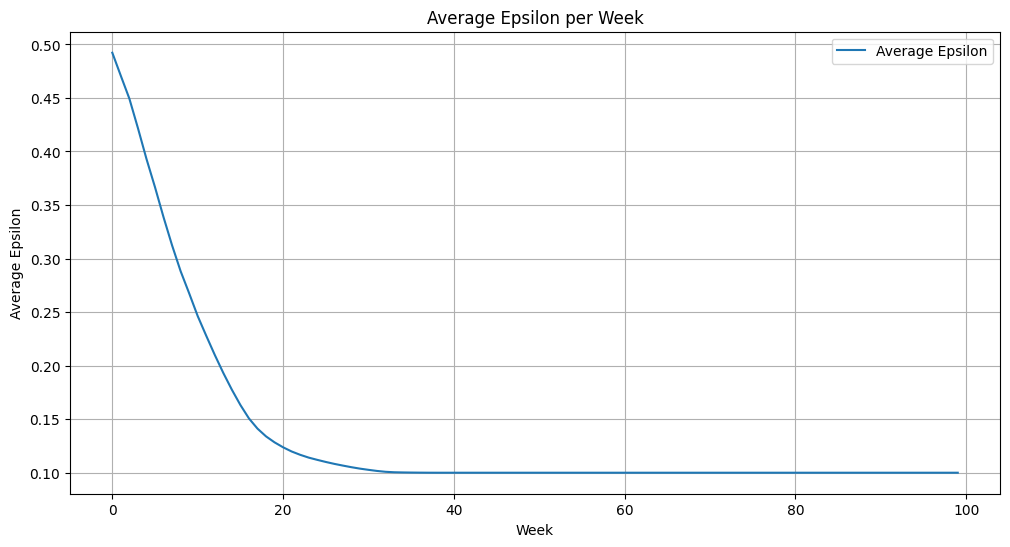

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(range(WEEKS), epsilon_tracking, label='Average Epsilon')
plt.title('Average Epsilon per Week')
plt.xlabel('Week')
plt.ylabel('Average Epsilon')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Count the frequency of attendance values
attendance_frequency = Counter(history)

# Display the frequency
print("Attendance Frequency per Week:")
for attendance_value, frequency in sorted(attendance_frequency.items()):
    print(f"Attendance: {attendance_value}, Frequency: {frequency}")

Attendance Frequency per Week:
Attendance: 31, Frequency: 1
Attendance: 37, Frequency: 1
Attendance: 45, Frequency: 2
Attendance: 47, Frequency: 3
Attendance: 49, Frequency: 2
Attendance: 50, Frequency: 3
Attendance: 51, Frequency: 4
Attendance: 52, Frequency: 10
Attendance: 53, Frequency: 11
Attendance: 54, Frequency: 21
Attendance: 55, Frequency: 15
Attendance: 56, Frequency: 36
Attendance: 57, Frequency: 18
Attendance: 58, Frequency: 18
Attendance: 59, Frequency: 12
Attendance: 60, Frequency: 6
Attendance: 61, Frequency: 7
Attendance: 62, Frequency: 6
Attendance: 63, Frequency: 7
Attendance: 64, Frequency: 10
Attendance: 65, Frequency: 7
Attendance: 66, Frequency: 7
Attendance: 67, Frequency: 8
Attendance: 68, Frequency: 7
Attendance: 69, Frequency: 7
Attendance: 70, Frequency: 10
Attendance: 71, Frequency: 6
Attendance: 72, Frequency: 9
Attendance: 73, Frequency: 10
Attendance: 74, Frequency: 3
Attendance: 75, Frequency: 7
Attendance: 76, Frequency: 4
Attendance: 77, Frequency: 2
A

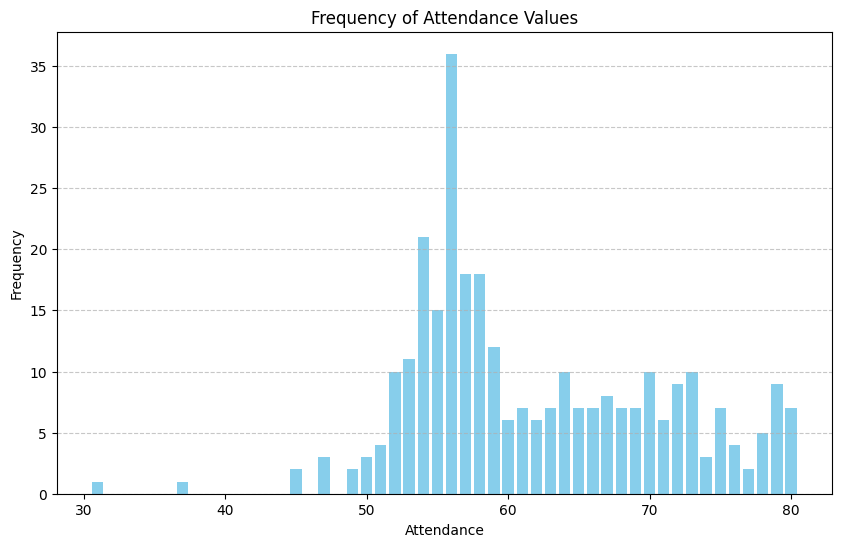

In [ ]:
# Visualize the frequency of attendance values
plt.figure(figsize=(10, 6))
plt.bar(attendance_frequency.keys(), attendance_frequency.values(), color='skyblue')
plt.title('Frequency of Attendance Values')
plt.xlabel('Attendance')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

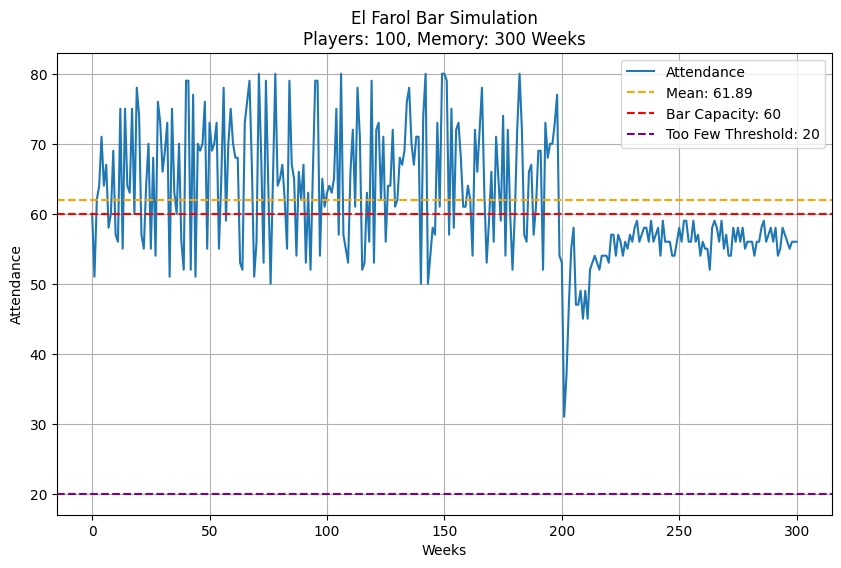

In [27]:
# Calculate the mean attendance
mean_data = np.mean(history)

# Plot the attendance history, mean, bar capacity, and too few threshold
plt.figure(figsize=(10, 6))
plt.plot(history, label='Attendance')
plt.axhline(y=mean_data, color='orange', linestyle='--', label='Mean: ' + str(round(mean_data, 2)))
plt.axhline(y=BAR_CAPACITY, color='red', linestyle='--', label='Bar Capacity: ' + str(BAR_CAPACITY))
plt.axhline(y=TOO_FEW, color='purple', linestyle='--', label='Too Few Threshold: ' + str(TOO_FEW))
plt.legend()
plt.xlabel("Weeks")
plt.ylabel("Attendance")
plt.grid()
plt.title("El Farol Bar Simulation\nPlayers: " + str(N_AGENTS) + ", Memory: " + str(SEQUENCE_LENGTH) + " Weeks")
plt.show()

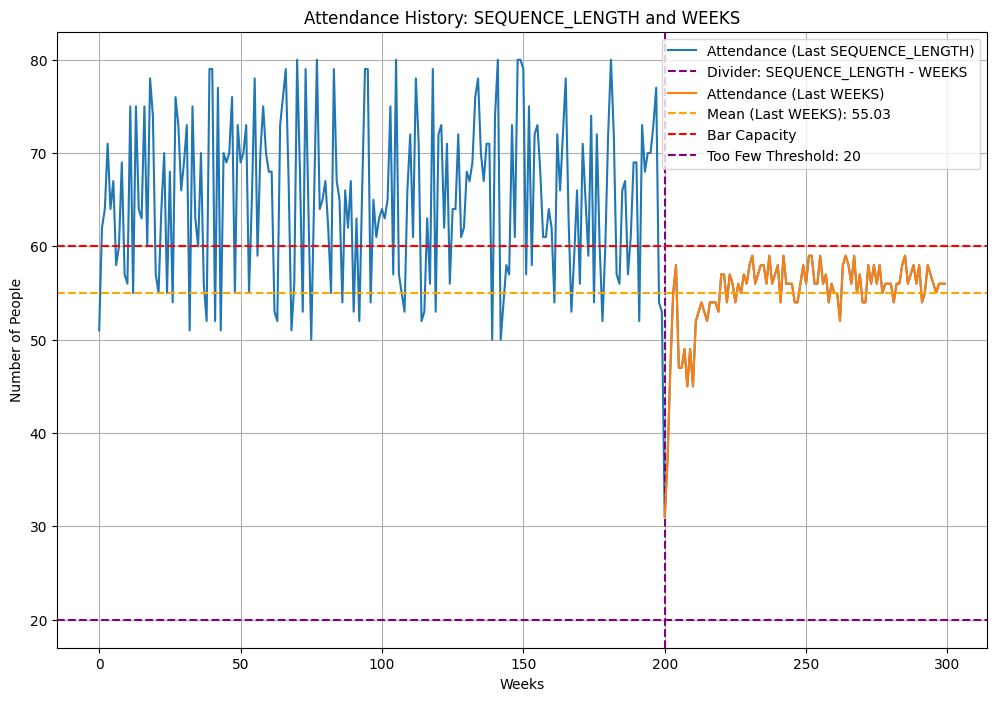

In [ ]:
# Plot attendance history for SEQUENCE_LENGTH and WEEKS
plt.figure(figsize=(12, 8))

# Plot data for SEQUENCE_LENGTH
plt.plot(range(SEQUENCE_LENGTH), history[-SEQUENCE_LENGTH:], label='Attendance (Last SEQUENCE_LENGTH)')

# Add a divider label
plt.axvline(x=SEQUENCE_LENGTH - WEEKS, color='purple', linestyle='--', label='Divider: SEQUENCE_LENGTH - WEEKS')

# Plot data for WEEKS
plt.plot(range(SEQUENCE_LENGTH - WEEKS, SEQUENCE_LENGTH), history[-WEEKS:], label='Attendance (Last WEEKS)')

# Calculate and plot the mean for the last WEEKS
mean_last_weeks = np.mean(history[-WEEKS:])
plt.axhline(y=mean_last_weeks, color='orange', linestyle='--', label='Mean (Last WEEKS): ' + str(round(mean_last_weeks, 2)))

# Add labels and legend
plt.axhline(y=BAR_CAPACITY, color='r', linestyle='--', label='Bar Capacity')
plt.axhline(y=TOO_FEW, color='purple', linestyle='--', label='Too Few Threshold: ' + str(TOO_FEW))
plt.title('Attendance History: SEQUENCE_LENGTH and WEEKS')
plt.xlabel('Weeks')
plt.ylabel('Number of People')
plt.legend()
plt.grid()
plt.show()

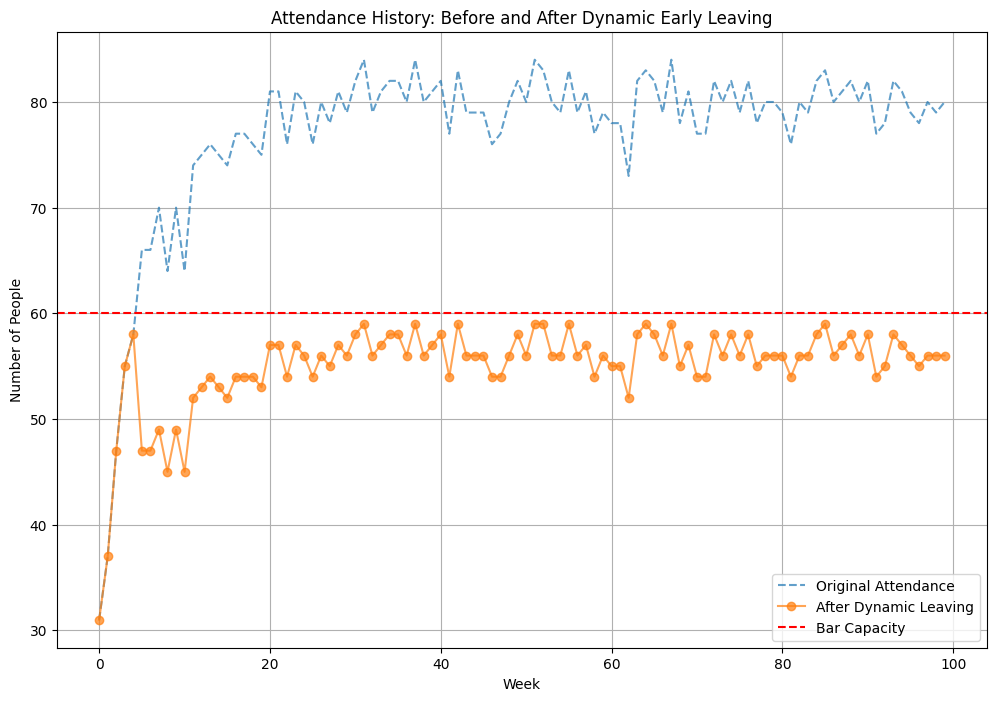

In [14]:
plt.figure(figsize=(12, 8))

# Plot original attendance (before dynamic early leaving)
plt.plot(range(WEEKS), raw_attendance, label='Original Attendance', linestyle='--', alpha=0.7)

# Plot attendance after applying early leaving
plt.plot(range(WEEKS), history[-WEEKS:], label='After Dynamic Leaving', marker='o', alpha=0.7)

# Bar capacity line
plt.axhline(y=BAR_CAPACITY, color='r', linestyle='--', label='Bar Capacity')

plt.title('Attendance History: Before and After Dynamic Early Leaving')
plt.xlabel('Week')
plt.ylabel('Number of People')
plt.legend()
plt.grid(True)
plt.show()

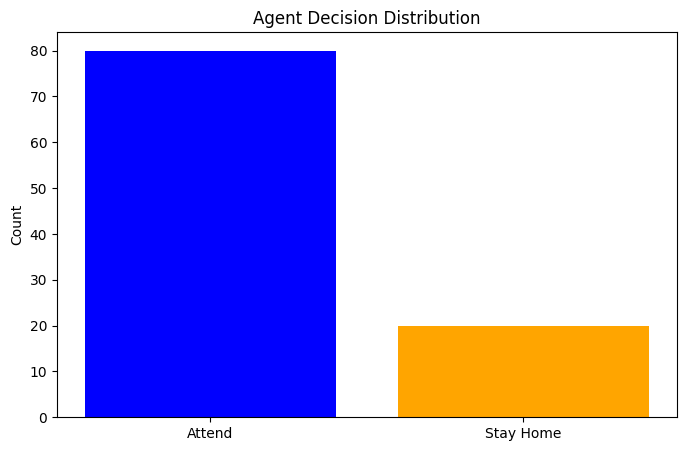

In [16]:
decisions_count = [sum(decisions), len(decisions) - sum(decisions)]
plt.figure(figsize=(8, 5))
plt.bar(['Attend', 'Stay Home'], decisions_count, color=['blue', 'orange'])
plt.title('Agent Decision Distribution')
plt.ylabel('Count')
plt.show()

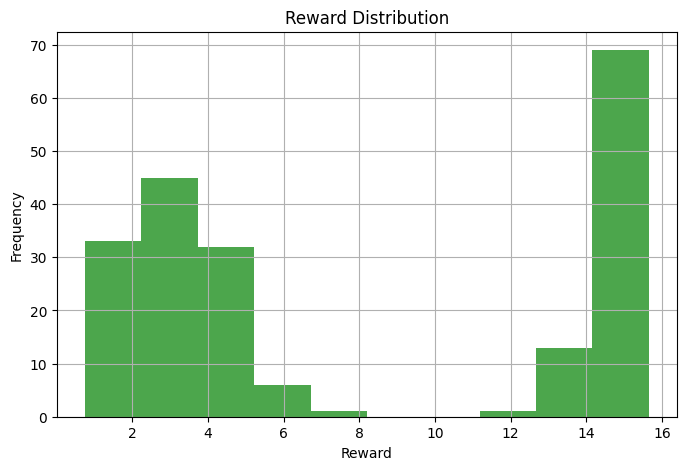

In [18]:
rewards = [reward for agent in agents for reward in agent.q_table]
plt.figure(figsize=(8, 5))
plt.hist(rewards, bins=10, color='green', alpha=0.7)
plt.title('Reward Distribution')
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.grid()
plt.show()

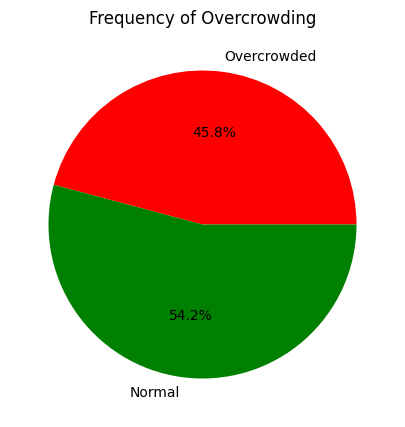

In [32]:
overcrowded_weeks = sum(1 for a in history if a > BAR_CAPACITY)
normal_weeks = len(history) - overcrowded_weeks
plt.figure(figsize=(8, 5))
plt.pie([overcrowded_weeks, normal_weeks], labels=['Overcrowded', 'Normal'], autopct='%1.1f%%', colors=['red', 'green'])
plt.title('Frequency of Overcrowding')
plt.show()

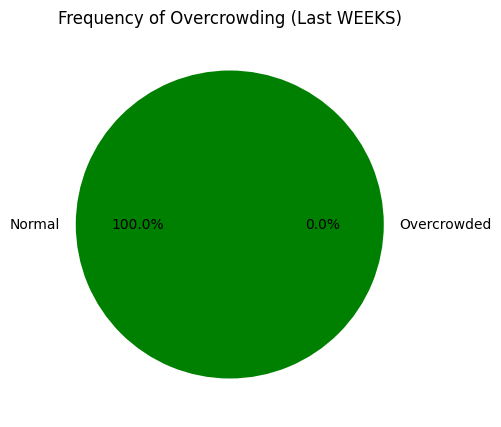

In [31]:
overcrowded_weeks = sum(1 for a in history[-WEEKS:] if a > BAR_CAPACITY)
normal_weeks = WEEKS - overcrowded_weeks
plt.figure(figsize=(8, 5))
plt.pie([overcrowded_weeks, normal_weeks], labels=['Overcrowded', 'Normal'], autopct='%1.1f%%', colors=['red', 'green'])
plt.title('Frequency of Overcrowding (Last WEEKS)')
plt.show()

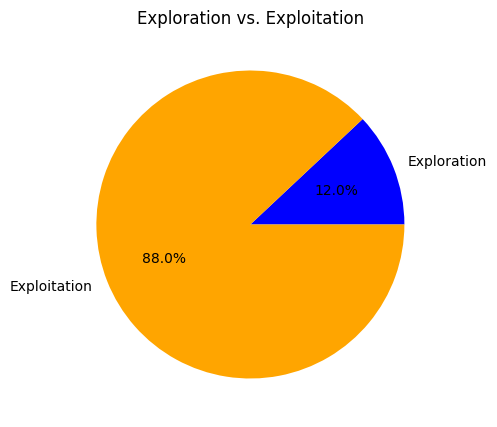

In [20]:
exploration_count = sum(1 for agent in agents if random.random() < agent.epsilon)
exploitation_count = len(agents) - exploration_count
plt.figure(figsize=(8, 5))
plt.pie([exploration_count, exploitation_count], labels=['Exploration', 'Exploitation'], autopct='%1.1f%%', colors=['blue', 'orange'])
plt.title('Exploration vs. Exploitation')
plt.show()

In [ ]:
for idx, agent in enumerate(agents):
    print(f"Agent {idx}:")
    print(f"  Q-Table: {agent.q_table}")
    print(f"  Epsilon: {agent.epsilon}")
    print(f"  Past Attendance: {agent.past_attendance}")
    print()

Agent 0:
  Q-Table: [3.75734132 2.05987733]
  Epsilon: 0.1
  Past Attendance: [65, 54, 57, 70, 76, 58, 50, 52, 79, 73, 79, 75, 55, 75, 71, 51, 60, 74, 60, 58, 70, 75, 76, 53, 64, 57, 75, 68, 58, 66, 73, 80, 65, 58, 54, 68, 52, 76, 74, 71, 58, 54, 57, 59, 55, 74, 75, 51, 52, 80, 68, 67, 57, 72, 58, 60, 69, 56, 70, 63, 76, 51, 50, 78, 56, 57, 80, 75, 74, 64, 68, 64, 69, 52, 54, 54, 50, 56, 54, 65, 52, 72, 54, 60, 66, 60, 79, 56, 71, 67, 68, 59, 64, 67, 67, 70, 74, 63, 70, 75, 52, 73, 60, 70, 54, 51, 55, 55, 79, 79, 67, 52, 64, 50, 73, 66, 57, 75, 51, 72, 77, 56, 58, 65, 72, 56, 73, 52, 75, 56, 78, 76, 77, 75, 64, 68, 62, 76, 68, 79, 60, 77, 66, 53, 61, 69, 53, 71, 54, 52, 65, 76, 72, 68, 73, 57, 55, 70, 56, 67, 65, 76, 53, 71, 62, 72, 72, 79, 60, 77, 57, 61, 76, 62, 74, 59, 68, 59, 67, 51, 76, 61, 71, 63, 62, 76, 53, 56, 77, 74, 61, 52, 66, 59, 68, 52, 63, 65, 74, 50, 57, 31, 37, 47, 55, 58, 47, 47, 49, 45, 49, 45, 52, 53, 54, 53, 52, 54, 54, 54, 53, 57, 57, 54, 57, 56, 54, 56, 55, 57, 5